In [38]:
import numpy as np
import pandas as pd
from collections import Counter
import warnings
warnings.filterwarnings("ignore")


In [39]:
class Node:
  def __init__(self, feature = None, threshold = None, data_left = None , data_right = None,
               gain = None, value = None, gini = None, entropy = None):
    self.feature = feature
    self.threshold = threshold
    self.data_left = data_left
    self.data_right = data_right
    self.gain = gain
    self.value = value
    self.gini = gini
    self.entorpy = entropy


In [40]:
class DecisionTree:
    def __init__(self, min_samples_split=25, max_depth=100):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None

    @staticmethod
    def Entropy(s):
        counts = np.bincount(np.array(s, dtype=np.int64))
        percentages = counts / len(s)
        ent = 0
        for pct in percentages:
            if pct > 0:
                ent -= pct * np.log2(pct)
        return ent

    def info_gain(self, parent, left_child, right_child):
        num_left = len(left_child) / len(parent)
        num_right = len(right_child) / len(parent)
        gain = self.Entropy(parent) - (num_left * self.Entropy(left_child) + num_right * self.Entropy(right_child))
        return gain

    def best_split(self, df):
        X = df[:, :-1]
        y = df[: , -1]
        best_split = {}
        best_info_gain = -1    #هر چه بیشتر باشد بهتر است.
        best_gini = 1.0         #هر چه کمتر باشد بهتر است.
        for f_idx in range(X.shape[1]):
            X_curr = X[:, f_idx]
            thresholds = np.unique(X_curr)
            for threshold in thresholds:
                df_left = df[X_curr <= threshold]
                df_right = df[X_curr > threshold]
                if len(df_left) > 0 and len(df_right) > 0:
                    y = np.concatenate((X, y.reshape(-1, 1)), axis=1)[:, -1]
                    y_left = df_left[:, -1]
                    y_right = df_right[:, -1]
                    gain = self.info_gain(y, y_left, y_right)
                    gini = self._gini_index(X, y, f_idx, threshold)
                    if gini < best_gini:
                        best_gini = gini
                        best_split = {
                            'feature_index': f_idx,
                            'threshold': threshold,
                            'df_left': df_left,
                            'df_right': df_right,
                            'gain': gain,
                            'gini': gini
                        }
        # unique_pairs = set((key, tuple(value)) if isinstance(value, np.ndarray) else (key, value) for key, value in best_split.items())
        # print('******************************')
        return best_split

    def build(self, X, y, depth=0):
        df = np.concatenate((X, y.reshape(-1, 1)), axis=1)
        if X.shape[0] >= self.min_samples_split and depth <= self.max_depth:

            best = self.best_split(df)
            if best['gain'] > 0:
                left = self.build(
                    X=best['df_left'][:, :-1],
                    y=best['df_left'][:, -1],
                    depth=depth + 1
                )
                right = self.build(
                    X=best['df_right'][:, :-1],
                    y=best['df_right'][:, -1],
                    depth=depth + 1
                )
                return Node(
                    feature=best['feature_index'],
                    threshold=best['threshold'],
                    data_left=left,
                    data_right=right,
                    gain=best['gain']
                )
        return Node(
            value=Counter(y).most_common(1)[0][0]
        )

    def _gini_impurity(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        gini = 1 - np.sum(probabilities ** 2)
        return gini

    def _gini_index(self, X, y, feature_index, threshold):
        left_labels = y[X[:, feature_index] <= threshold]
        right_labels = y[X[:, feature_index] > threshold]

        left_gini = self._gini_impurity(left_labels)
        right_gini = self._gini_impurity(right_labels)

        num_left = len(left_labels)
        num_right = len(right_labels)

        total_samples = len(X)
        gini_index = (num_left / total_samples) * left_gini + (num_right / total_samples) * right_gini
        return gini_index

    def fit(self, X, y):
        self.root = self.build(X, y)

    def _predict(self, x, tree):
        if tree.value is not None:
            return tree.value
        feature_value = x[tree.feature]
        if feature_value <= tree.threshold:
            return self._predict(x, tree.data_left)
        if feature_value > tree.threshold:
            return self._predict(x, tree.data_right)

    def predict(self, X):
        return [self._predict(x, self.root) for x in X]

# New Section

In [41]:
data = pd.read_csv('Airplane.csv')
data.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [42]:
data.tail()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
103899,103899,94171,Female,disloyal Customer,23,Business travel,Eco,192,2,1,...,2,3,1,4,2,3,2,3,0.0,neutral or dissatisfied
103900,103900,73097,Male,Loyal Customer,49,Business travel,Business,2347,4,4,...,5,5,5,5,5,5,4,0,0.0,satisfied
103901,103901,68825,Male,disloyal Customer,30,Business travel,Business,1995,1,1,...,4,3,2,4,5,5,4,7,14.0,neutral or dissatisfied
103902,103902,54173,Female,disloyal Customer,22,Business travel,Eco,1000,1,1,...,1,4,5,1,5,4,1,0,0.0,neutral or dissatisfied
103903,103903,62567,Male,Loyal Customer,27,Business travel,Business,1723,1,3,...,1,1,1,4,4,3,1,0,0.0,neutral or dissatisfied


In [43]:
data.columns

Index(['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

In [44]:
df = {'Alt': ['yes', 'yes', 'no', 'yes','yes','no', 'no','no', 'no','yes', 'no', 'yes'],
             'Bar':['no', 'no','yes','no', 'no','yes', 'yes', 'no', 'yes', 'yes','no', 'yes'],
             'Fri': ['no', 'no','no','yes', 'yes', 'no', 'no', 'no','yes', 'yes','no', 'yes'],
             'Hun': ['yes', 'yes', 'no', 'yes','no','yes','no', 'yes','no','yes','no', 'yes' ],
             'Pat' :['some', 'full','some', 'full','full','some', None, 'Some', 'full','full',None, 'full'],
             'price':['$$$','$','$','$','$$$','$$','$','$$','$','$$$','$','$'],
             'Rain':['no','no','no','yes','no','yes','yes','yes','yes','no','no','no'],
             'Res':['yes','no','no','no','yes','yes','no','yes','no','yes','no','no'],
             'Type': ['French','Tai', 'Burger','Thai','French', 'italian','Burger','Thai','Burger','italian','Thai', 'burger'],
             'est': ['0-10', '30-60', '0_10','10_30','>60','0-10','0-10','0-10','>60', '10-30','0-10','30-60'],
             'target':['yes','no','yes','yes','no','yes','no','yes','no','no','no','yes']
             }
restaurant = pd.DataFrame(df)
restaurant


,Alt,Bar,Fri,Hun,Pat,price,Rain,Res,Type,est,target
0,yes,no,no,yes,some,$$$,no,yes,French,0-10,yes
1,yes,no,no,yes,full,$,no,no,Tai,30-60,no
2,no,yes,no,no,some,$,no,no,Burger,0_10,yes
3,yes,no,yes,yes,full,$,yes,no,Thai,10_30,yes
4,yes,no,yes,no,full,$$$,no,yes,French,>60,no
5,no,yes,no,yes,some,$$,yes,yes,italian,0-10,yes
6,no,yes,no,no,None,$,yes,no,Burger,0-10,no
7,no,no,no,yes,Some,$$,yes,yes,Thai,0-10,yes
8,no,yes,yes,no,full,$,yes,no,Burger,>60,no
9,yes,yes,yes,yes,full,$$$,no,yes,italian,10-30,no


In [45]:
restaurant.columns

Index(['Alt', 'Bar', 'Fri', 'Hun', 'Pat', 'price', 'Rain', 'Res', 'Type',
       'est', 'target'],
      dtype='object')

In [46]:
from sklearn.preprocessing import LabelEncoder
columns_to_convert = ['Alt', 'Bar', 'Fri', 'Hun', 'Pat', 'price', 'Rain', 'Res', 'Type', 'est', 'target']
label_encoder1 = LabelEncoder()
for column in columns_to_convert:
    restaurant[column] = label_encoder1.fit_transform(restaurant[column])
restaurant.head()

,Alt,Bar,Fri,Hun,Pat,price,Rain,Res,Type,est,target
0,1,0,0,1,2,2,0,1,1,0,1
1,1,0,0,1,1,0,0,0,2,4,0
2,0,1,0,0,2,0,0,0,0,1,1
3,1,0,1,1,1,0,1,0,3,3,1
4,1,0,1,0,1,2,0,1,1,5,0


In [47]:

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

X = restaurant.iloc[:, :-1]
y = restaurant.iloc[:, -1]
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Split the data into train and test sets
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_imputed.values, y.values, test_size=0.3, random_state=42)


model3 = DecisionTree()
model3.fit(X_train3, y_train3)
preds3 = model3.predict(X_test3)

In [48]:
res_rest = accuracy_score(y_test3, preds3)
res_rest

0.25

In [49]:
from sklearn.preprocessing import LabelEncoder
columns_to_convert = ['Gender','Customer Type','Type of Travel', 'Class','satisfaction']
label_encoder = LabelEncoder()
for column in columns_to_convert:
    data[column] = label_encoder.fit_transform(data[column])

In [50]:
data.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,1,0,13,1,2,460,3,4,...,5,4,3,4,4,5,5,25,18.0,0
1,1,5047,1,1,25,0,0,235,3,2,...,1,1,5,3,1,4,1,1,6.0,0
2,2,110028,0,0,26,0,0,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,1
3,3,24026,0,0,25,0,0,562,2,5,...,2,2,5,3,1,4,2,11,9.0,0
4,4,119299,1,0,61,0,0,214,3,3,...,3,3,4,4,3,3,3,0,0.0,1


In [51]:
data.shape

(103904, 25)

In [52]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score
X = data.iloc[:3000, :-1]
y = data.iloc[:3000, -1]
imputer = KNNImputer(n_neighbors=3)
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
from sklearn.model_selection import train_test_split
np.random.seed(42)

indices = np.arange(len(X))
np.random.shuffle(indices)

split_ratio = 0.8
train_size = int(split_ratio * len(X))

X_train = X_imputed.iloc[indices[:train_size]].values
y_train = y[indices[:train_size]].values
X_test = X_imputed.iloc[indices[train_size:]].values
y_test = y[indices[train_size:]].values
sk_model = DecisionTreeClassifier()
sk_model.fit(X_train, y_train)
sk_preds = sk_model.predict(X_test)
# print(type(X_train1))
# print(type(X_train))
res_pack = accuracy_score(y_test, sk_preds)
print('the accuracy of decisionTree of sklearn is :', res_pack)

the accuracy of decisionTree of sklearn is : 0.9033333333333333


In [53]:
model = DecisionTree()
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [54]:
res_mytree1 = accuracy_score(y_test, preds)

In [55]:
print('the accuracy of my implementation tree is : ', res_mytree1)

the accuracy of my implementation tree is :  0.915


In [56]:
if res_pack < res_mytree1:
    print('the accuracy of decision tree from scratch is better than decision Tree from sklearn model.')
else:
    print('the accuracy of decision Tree from sklearn model is better than decision tree from scratch.')

the accuracy of decision tree from scratch is better than decision Tree from sklearn model.


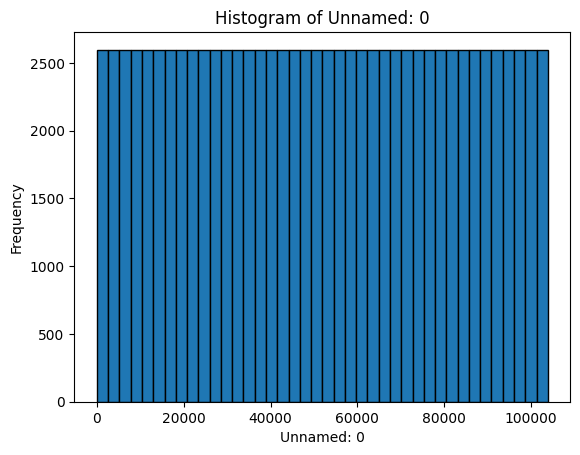

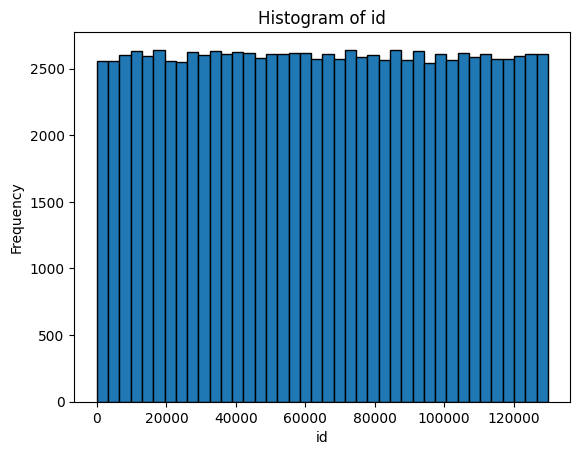

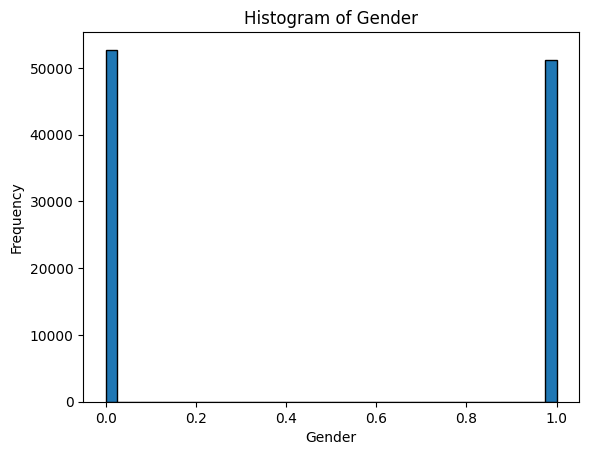

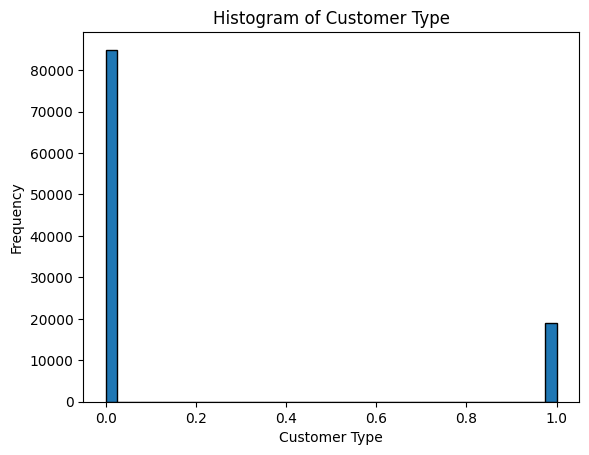

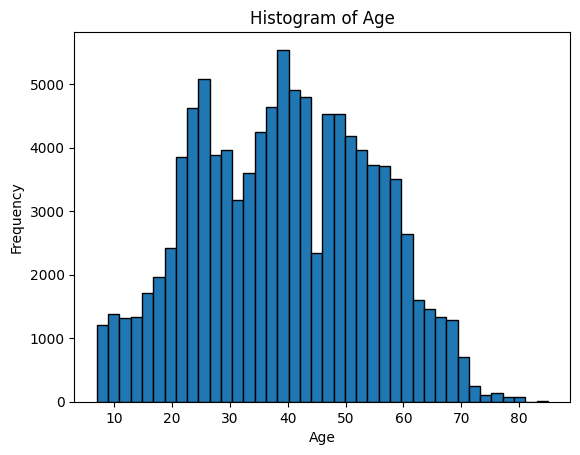

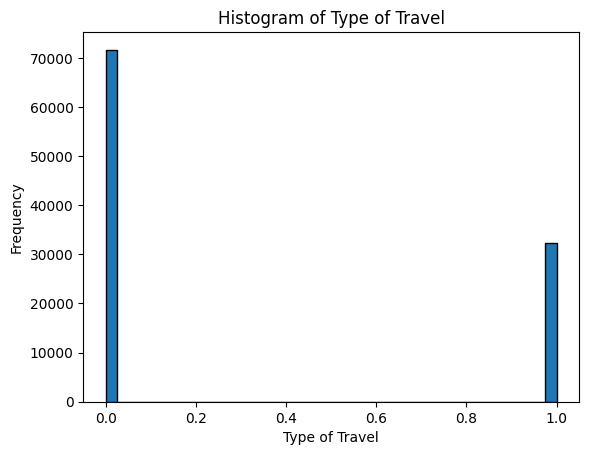

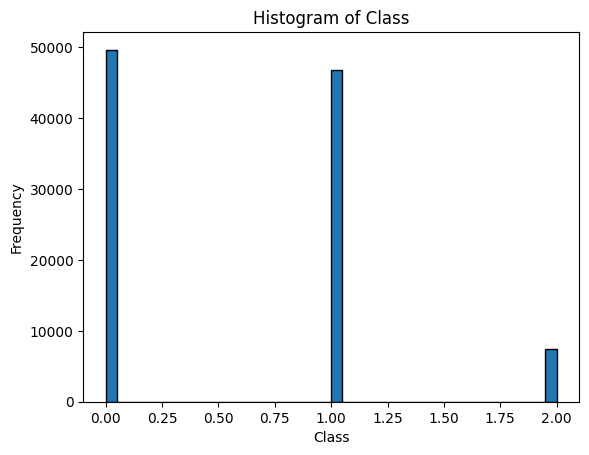

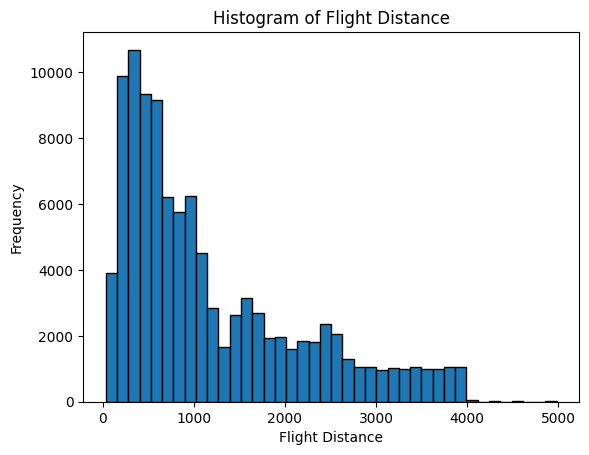

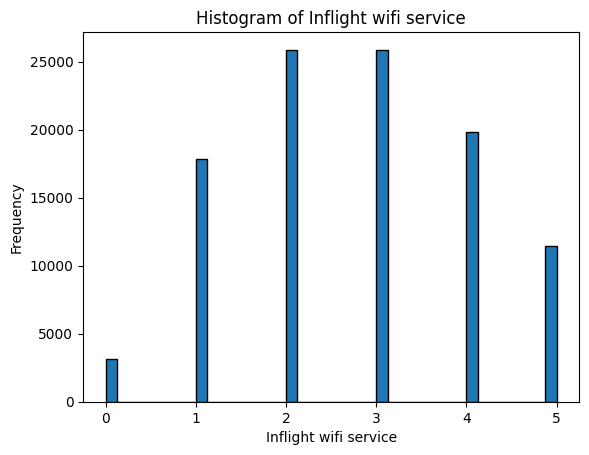

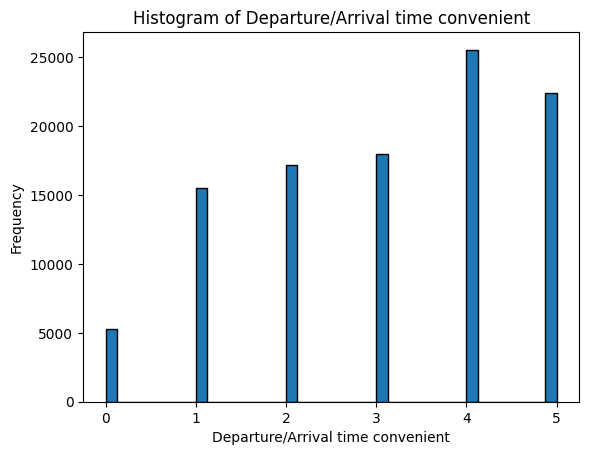

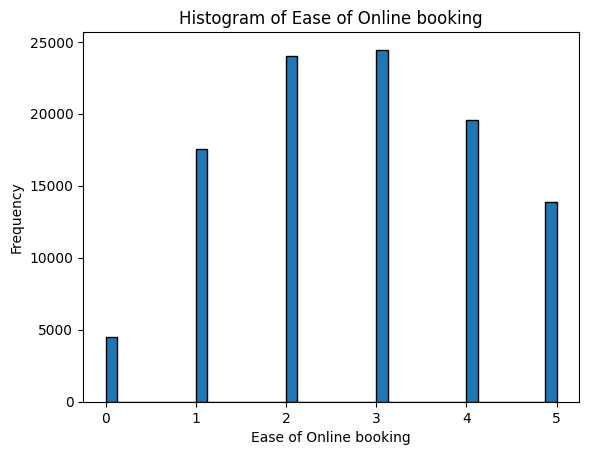

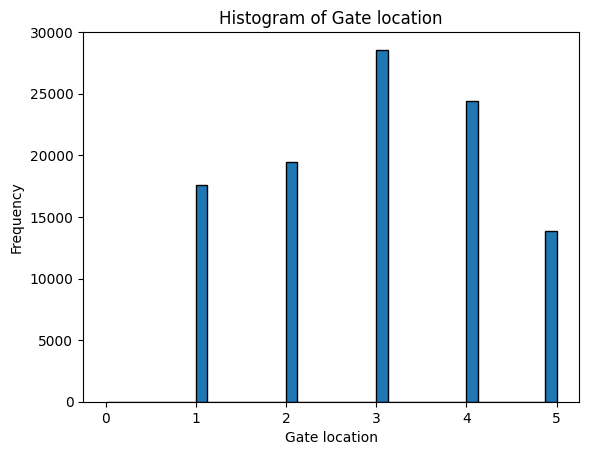

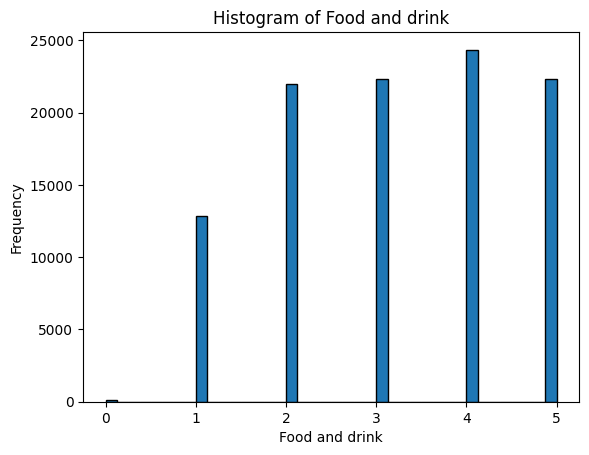

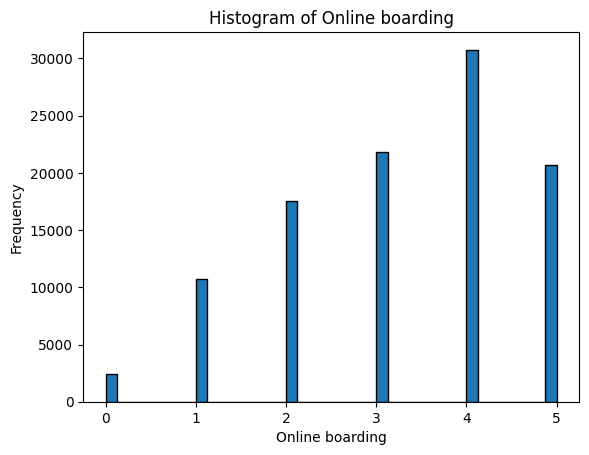

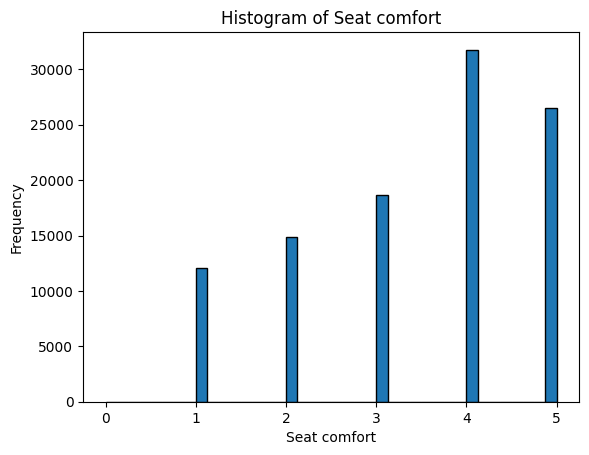

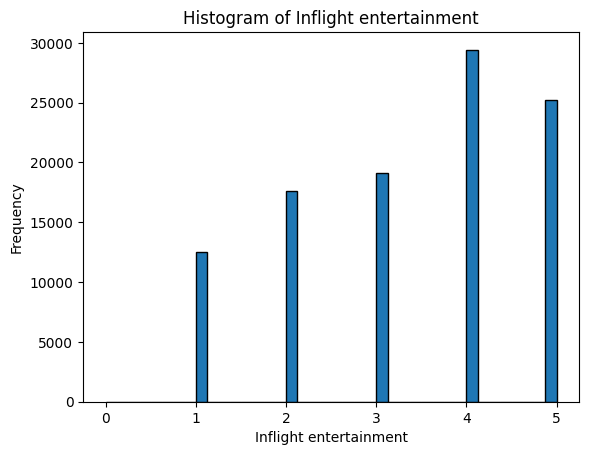

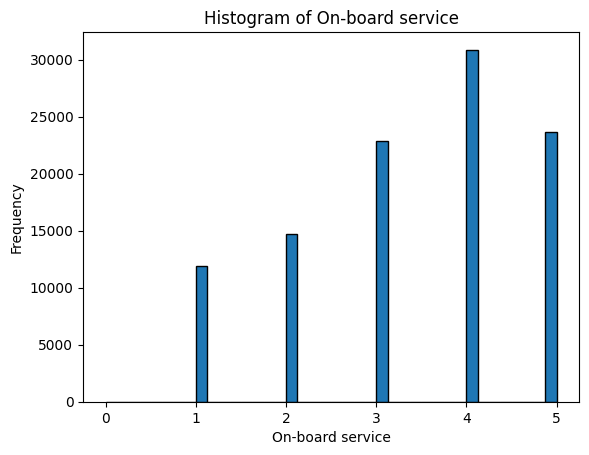

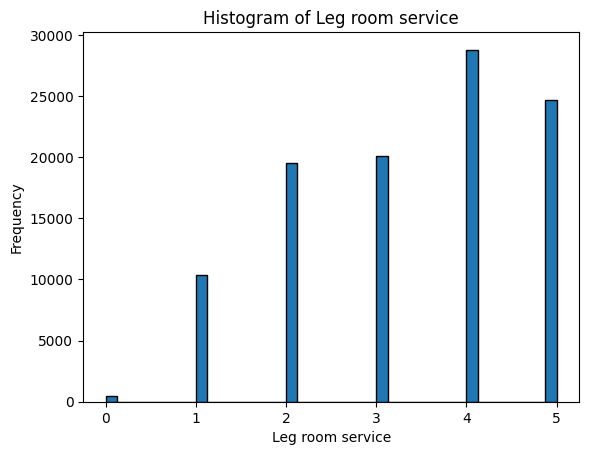

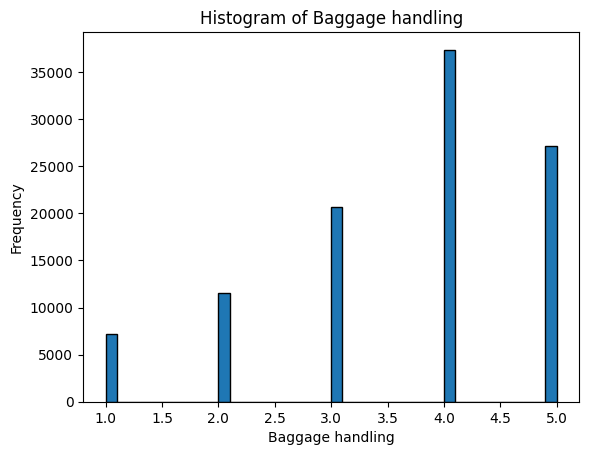

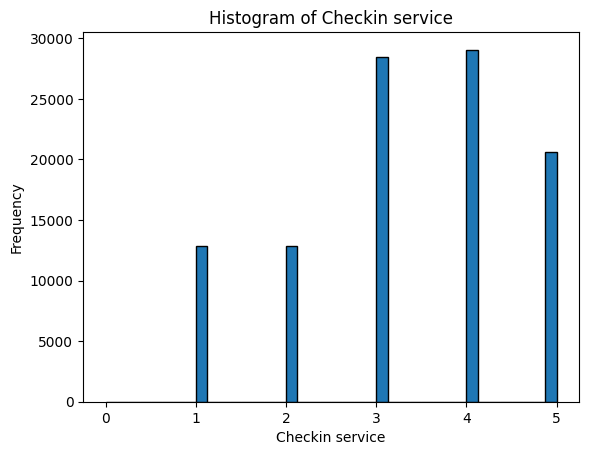

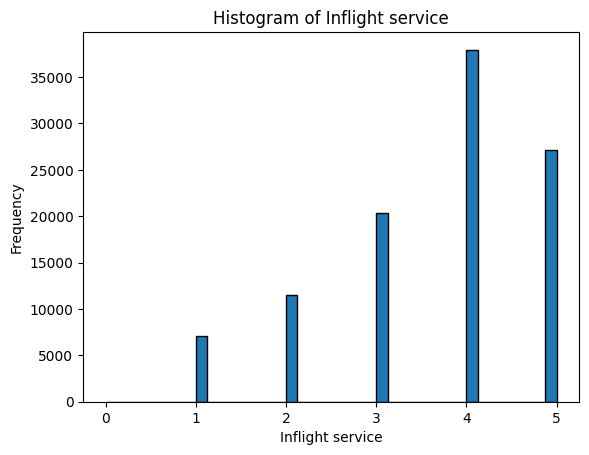

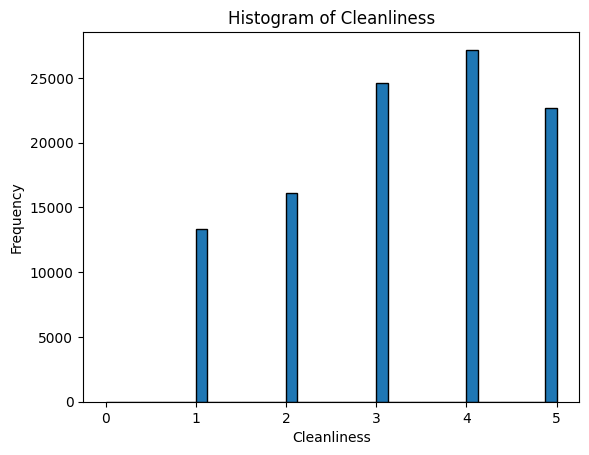

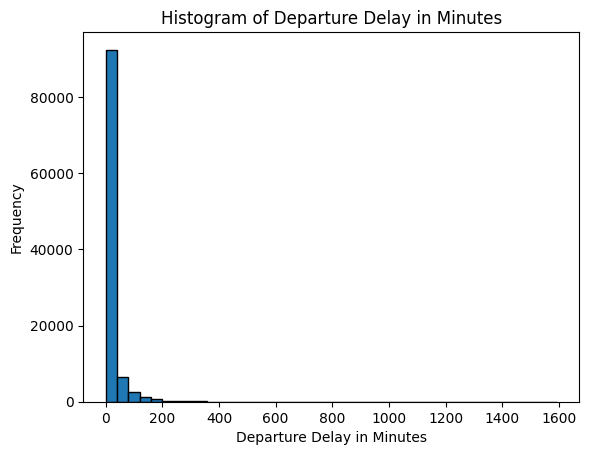

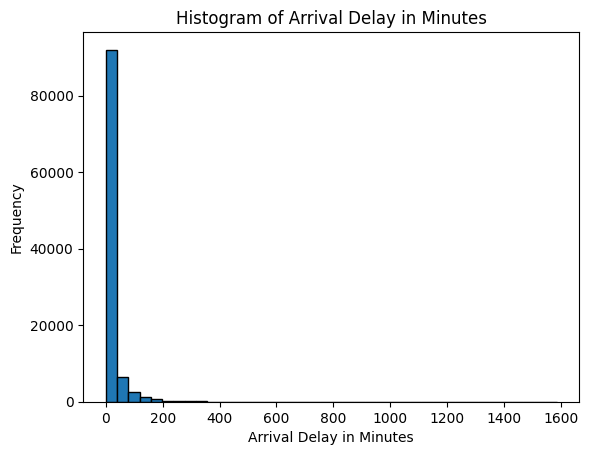

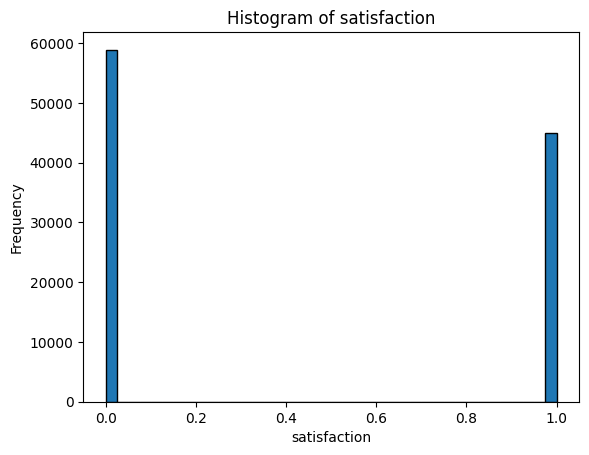

In [57]:
import matplotlib.pyplot as plt
for column in data.columns:
    plt.hist(data[column], bins=40, edgecolor='black')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.show()

In [58]:
correlation_matrix = data.corr()

# Display the correlation matrix
print(correlation_matrix)

                                   Unnamed: 0        id    Gender  \
Unnamed: 0                           1.000000  0.002991  0.003978   
id                                   0.002991  1.000000 -0.000606   
Gender                               0.003978 -0.000606  1.000000   
Customer Type                       -0.002844  0.000145 -0.031732   
Age                                  0.004786  0.022857  0.008928   
Type of Travel                       0.000856  0.000475  0.006909   
Class                               -0.001134 -0.104338 -0.012870   
Flight Distance                      0.002794  0.095544  0.005828   
Inflight wifi service               -0.002490 -0.021276  0.008974   
Departure/Arrival time convenient    0.000739 -0.002110  0.009142   
Ease of Online booking               0.001913  0.014163  0.006951   
Gate location                        0.005073 -0.000606  0.000333   
Food and drink                      -0.002162  0.001063  0.005772   
Online boarding                   

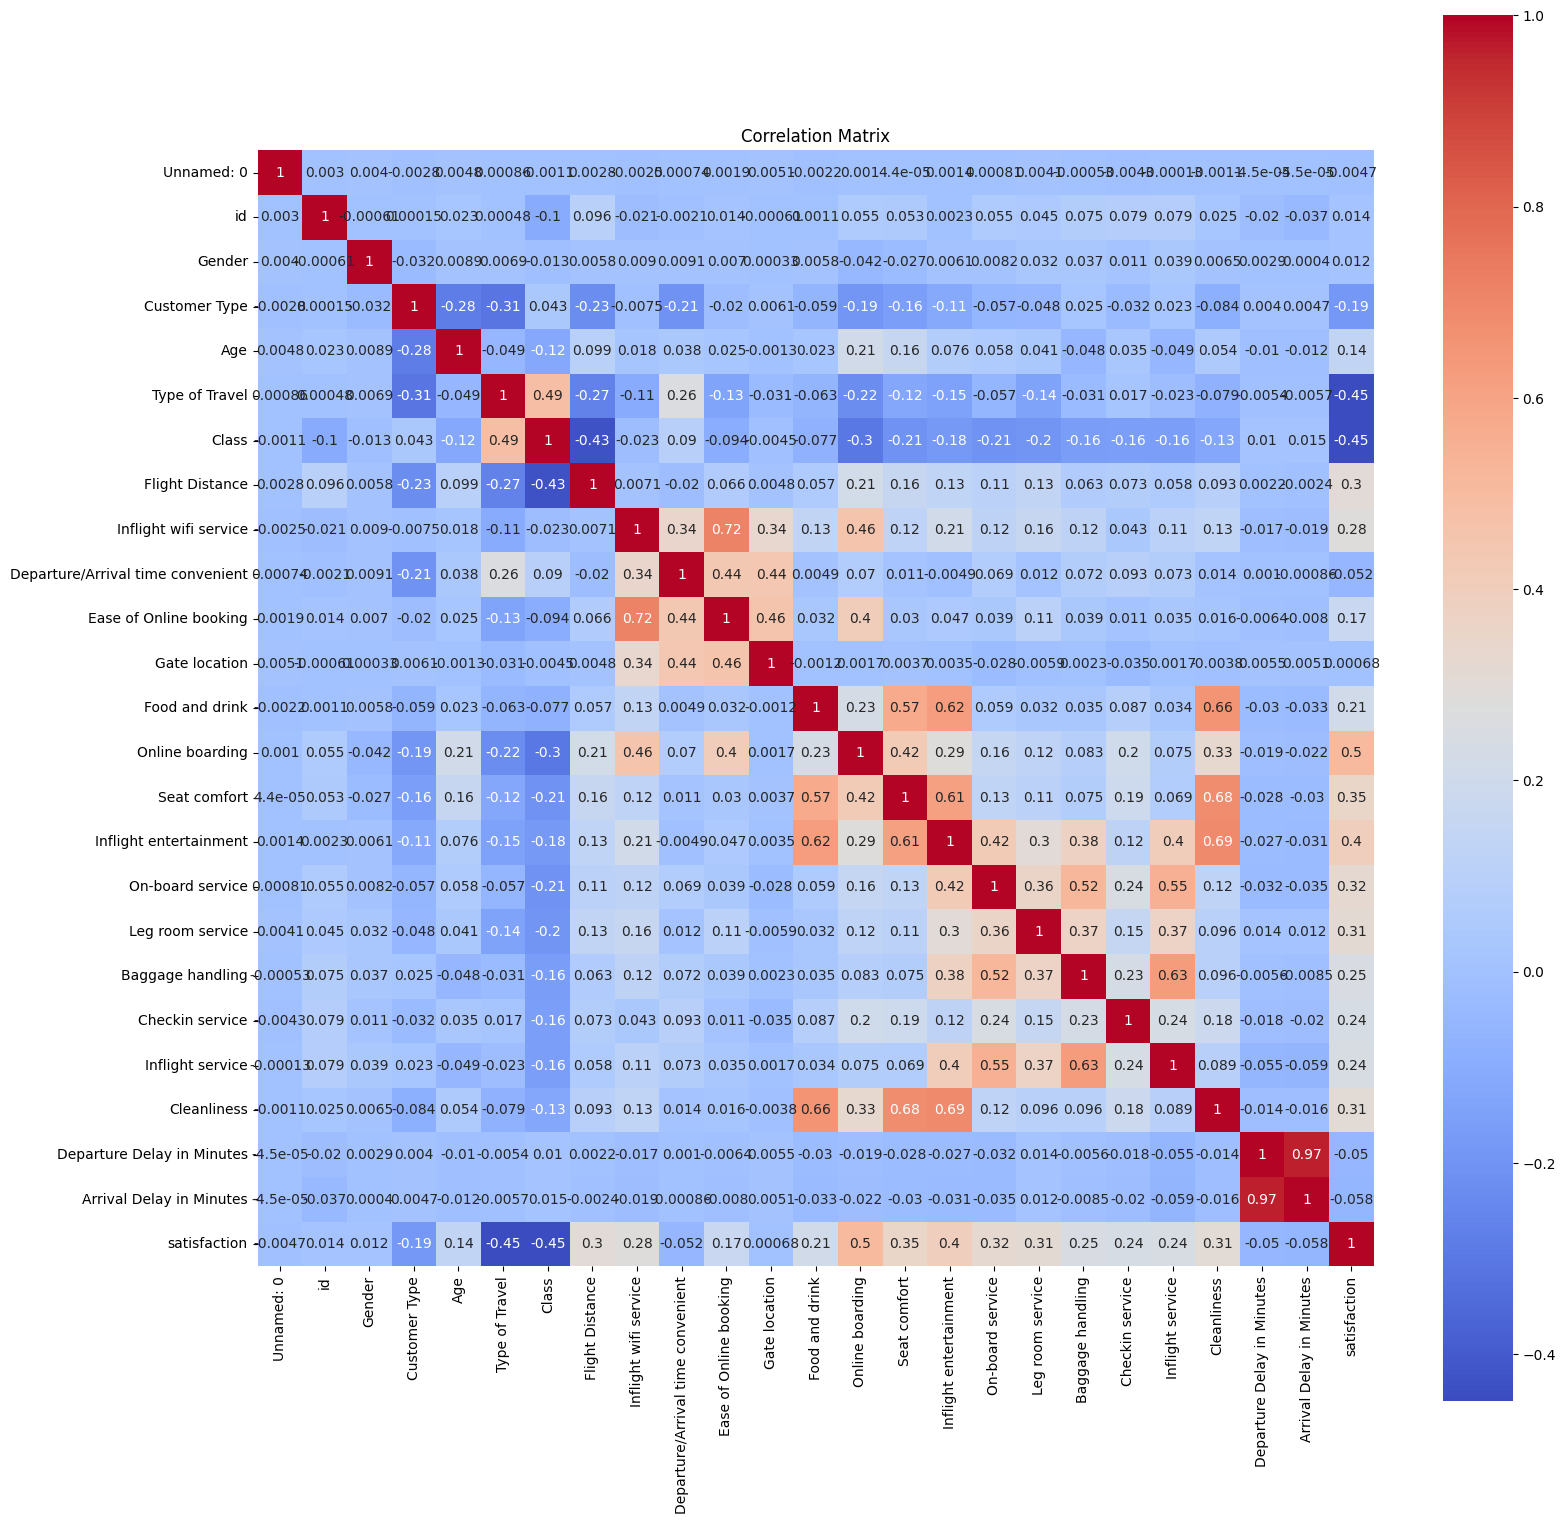

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the correlation matrix heatmap
plt.figure(figsize=(18, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)

# Add title
plt.title('Correlation Matrix')

# Show the plot
plt.show()

In [60]:
print("according to the heatmap we can delete the Gate Location feature and after that analyse it again")

according to the heatmap we can delete the Gate Location feature and after that analyse it again


In [61]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

columns_to_standardize = data.columns
scaler = StandardScaler()
scaler.fit(data[columns_to_standardize])
data[columns_to_standardize] = scaler.transform(data[columns_to_standardize])

# Display the standardized DataFrame
print(data)

        Unnamed: 0        id    Gender  Customer Type       Age  \
0        -1.732034  0.140077  1.015031      -0.472767 -1.745279   
1        -1.732001 -1.598276  1.015031       2.115208 -0.951360   
2        -1.731967  1.203935 -0.985192      -0.472767 -0.885200   
3        -1.731934 -1.091678 -0.985192      -0.472767 -0.951360   
4        -1.731901  1.451402  1.015031      -0.472767  1.430397   
...            ...       ...       ...            ...       ...   
103899    1.731901  0.780671 -0.985192       2.115208 -1.083680   
103900    1.731934  0.218153  1.015031      -0.472767  0.636478   
103901    1.731967  0.104122  1.015031       2.115208 -0.620561   
103902    1.732001 -0.286977 -0.985192       2.115208 -1.149840   
103903    1.732034 -0.062920  1.015031      -0.472767 -0.819040   

        Type of Travel     Class  Flight Distance  Inflight wifi service  \
0             1.490614  2.264618        -0.731539               0.203579   
1            -0.670865 -0.957054        -0.

In [62]:
data.columns

Index(['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

X = data.iloc[:5000, :-1]
y = data.iloc[:5000, -1]
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Split the data into train and test sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_imputed.values, y.values, test_size=0.4, random_state=42)


model2 = DecisionTree()
model2.fit(X_train1, y_train1)
preds1 = model2.predict(X_test1)

In [ ]:
# res_mytree2 = accuracy_score(y_test1, preds1)
# print('accuracy_score after standardization is : ', res_mytree2)
# difference = np.abs(res_mytree2 - res_mytree1)
# print("the difference between accuracy score before and after standardazation is:", difference)